<pre>
1. Download the Italian to English translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find ita.txt file in that ZIP, you can read that data using python and preprocess that data. 

3. You have to implement an Encoder and Decoder architecture with Luong attention.

Encoder   - with 1 layer LSTM 
Decoder   - with 1 layer LSTM
attention - Luone attention. (Please refer the reference notebook to know more about the attention mechanisum.)

4. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook). As a part of this assignment <strong>you need to create 3 models for each scoring function.</strong>
<img src='https://i.imgur.com/iD2jZo3.png'>
    In model 1 you need to implemnt "dot" score function
    In model 2 you need to implemnt "general" score function
    In model 3 you need to implemnt "concat" score function
    

    <strong>Please do add the markdown titles for each model  so that we can have a better look at the code and verify.</strong>

5. Using attention weights, you can plot the attention plots, please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. You can use any tf.Keras highlevel API's to build and train the models. Check the reference notebook for better understanding.

8. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

9. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

10. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    

Note 1:  There are many blogs on the attention mechanisum which might be misleading you, so do read the references completly and after that only please check the internet. the best things is to read the research papers and try to implement it on your own. 

Note 2: To complete this assignment, the reference that are mentioned will be enough.

Note 3: If you are starting this assignment, you might have completed minimum of 20 assignment. If  you are still not able to implement this algorithm you might have rushed in the previous assignments with out learning much and didn't spend your time productively.
</pre>

In [0]:
#Referneces 
# https://www.tensorflow.org/tutorials/text/nmt_with_attention
# https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
# https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/
# https://arxiv.org/pdf/1508.04025.pdf

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#loading packages

import tensorflow as tf
tf.executing_eagerly()
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM
from tensorflow.keras.models import Model
import numpy as np
import unicodedata

%tensorflow_version 2.x
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
import tqdm
import re
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split

In [0]:
# https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/
#Normalising the text data 

def unicode_to_ascii(s):
  return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
      )
def normalize_string(s):
  s = unicode_to_ascii(s)
  s = s.replace(r'.', r' .')
  s = s.replace(r'!', r' !')
  s = s.replace(r'?', r' ?')
  return s

In [62]:
#Data PreProcessing

file = open(r'/content/drive/My Drive/Attention Models/ita.txt', '+r')

english = []
italian = []
output =[]

for i in tqdm.tqdm_notebook(file):
  sententce = normalize_string(str(i).split('\t')[0])
  english.append(sententce.split())
  
  sentence = normalize_string(str(i).split('\t')[1])
  sentence = '<start> '+sentence
  italian.append(sentence.split())

  sentence = normalize_string(str(i).split('\t')[1])
  sentence = sentence+' <end>'
  output.append(sentence.split())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [63]:
#Tokenization On english data
#Here We Are taking first 1,50,000 Sentence-pairs for getting less train complexity

en_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
en_tokenizer.fit_on_texts(english[:150000])
data_en = en_tokenizer.texts_to_sequences(english[:150000])
data_en = tf.keras.preprocessing.sequence.pad_sequences(data_en,
                                                        padding='post')
print('English sequences')
print(data_en[:2])

English sequences
[[1621    1    0    0    0    0    0    0    0]
 [ 394   80    0    0    0    0    0    0    0]]


In [64]:
#Tokenization On Decoder's Input Data
# For Teacher Forcing

ita_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
ita_tokenizer.fit_on_texts(italian[:150000])
ita_tokenizer.fit_on_texts(output[:150000])
data_ita_in = ita_tokenizer.texts_to_sequences(italian[:150000])
data_ita_in = tf.keras.preprocessing.sequence.pad_sequences(data_ita_in,
                                                           padding='post')
print('French input sequences')
print(data_ita_in[:2])

French input sequences
[[   2 3059   62    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   2 4163   62    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]]


In [65]:
#Tokenization On Decoder's Target Data

data_ita_out = ita_tokenizer.texts_to_sequences(output[:150000])
data_ita_out = tf.keras.preprocessing.sequence.pad_sequences(data_ita_out,
                                                            padding='post')
print('French output sequences')
print(data_ita_out[:2])

French output sequences
[[3059   62    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [4163   62    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]]


In [0]:
#Preparing Dataset For Customised Training
#With BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(
    (data_en, data_ita_in, data_ita_out))
dataset = dataset.shuffle(len(english)).batch(
    128, drop_remainder=True)

In [67]:
dataset

<BatchDataset shapes: ((128, 9), (128, 19), (128, 19)), types: (tf.int32, tf.int32, tf.int32)>

In [0]:
#Encoder - Class with 1 Layer LSTM
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, rnn_size):
    super(Encoder, self).__init__()
    self.rnn_size = rnn_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
    self.lstm = tf.keras.layers.LSTM(rnn_size, 
                                     return_sequences=True, 
                                     return_state=True)

  def call(self, sequence, states):
    embed = self.embedding(sequence)
    output, state_h, state_c = self.lstm(embed, initial_state=states)
    return output, state_h, state_c

  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.rnn_size]),
                tf.zeros([batch_size, self.rnn_size]))




#One-Step-Decoder With Luong-Style Attention
class OneStepDecoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, rnn_size, Score):
    super(OneStepDecoder, self).__init__()
    self.attention_func = attention_func
    self.rnn_size = rnn_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
    self.lstm = tf.keras.layers.LSTM(rnn_size,
                                     return_sequences=True,
                                     return_state=True)
    self.wc = tf.keras.layers.Dense(rnn_size, activation='tanh')
    self.ws = tf.keras.layers.Dense(vocab_size)

    if Score == 'general':
      # General score function
      self.wa = tf.keras.layers.Dense(rnn_size)
    elif Score == 'concat':
      # Concat score function
      self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
      self.va = tf.keras.layers.Dense(1)

  def call(self, decoder_input, encoder_output , state_h,state_c):

    # (1)Embedding
    embed = self.embedding(decoder_input)

    # (2)Passing Embedding Vector in LSTM Cell
    #shape (batch_size, 1, rnn_size)
    decoder_output, state_h, state_c = self.lstm(embed, initial_state=[state_h, state_c])
      
    if self.attention_func == 'dot':
      
      # (3) Calculating Dot Score 
      score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
    
    elif self.attention_func == 'general':
      
      # (3) Calculating General Score 
      score = tf.matmul(decoder_output, self.wa(encoder_output), 
                        transpose_b=True)
    
    elif self.attention_func == 'concat':
      #broadcasting Decoder_output for Concating it with encoder output
      dec_output = tf.tile(decoder_output, [1, encoder_output.shape[1], 1])
            
      # (3) Calculating Concat Score 
      score = self.va(tf.nn.tanh(self.wa(tf.concat((dec_output, encoder_output), axis=-1))))
      #(batch_size, 1, max_len)
      score = tf.transpose(score, [0, 2, 1])
          
    # (4)Applying Softmax Layer on  Score
    alignment = tf.nn.softmax(score, axis=2)
      
    # (5)Calculating Context Vector
    context = tf.matmul(alignment, encoder_output)
      
    # (6)Concate Lstm Output and Context Vector  
    lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(decoder_output, 1)], 1)

    # (7) passing the Results of step- 6 to Dense Layers for getting prediction
    lstm_out = self.wc(lstm_out)
    logits = self.ws(lstm_out)

    return logits, alignment,state_h,state_c


class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, rnn_size, attention_func):
    super(Decoder, self).__init__()
    self.attention = OneStepDecoder(vocab_size, embedding_size,rnn_size, attention_func)
        
  def call(self, sequence, state_h, state_c, encoder_outputs):
    outputs = tf.TensorArray(tf.float32, size=sequence.shape[1])
        
    #Passing Decoder's Input to the One-Step-Attention layer One by One for each Time stamp
    for timestamp in range(sequence.shape[1]):
      output, alignments, state_h, state_c = self.attention(sequence[:, timestamp:timestamp+1], 
                                                                 encoder_outputs, 
                                                                 state_h, 
                                                                 state_c)
        
      #Saving the results of timestamp t 
      outputs = outputs.write(timestamp, output)
      
    outputs = tf.transpose(outputs.stack(), [1,0,2])
    return outputs, state_h, state_c, alignments

**Model-1 -Dot_Score**

In [0]:
"Dot-Score"

In [0]:
#Combining the Both Encoder and Decoder Model for trainig

encoder = Encoder(len(en_tokenizer.word_index)+1, 300, 256)
decoder = Decoder(len(ita_tokenizer.word_index)+1, 300, 256, 'dot')
en_initial_states = encoder.init_states(128)
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)

In [0]:
#Loss Function for Training
# https://www.tensorflow.org/tutorials/text/nmt_with_attention
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

In [0]:
#Train_step Function for Applying BackPropogation for Custom Trainig
# https://www.tensorflow.org/tutorials/text/nmt_with_attention

@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        
        #taking State-h and State-c for Decoder 
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, de_state_h, de_state_c, en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    #Gradient Update
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

In [72]:
#Training Process

import time
for e in range(25):
  start = time.time()
  
  #Saving Weights
  encoder.save_weights(
            '/content/drive/My Drive/Attention Models/saved_model/Check/Encoder/encoder_{}.h5'.format(e + 1))
  decoder.save_weights(
            '/content/drive/My Drive/Attention Models/saved_model/Check/Decoder/decoder_{}.h5'.format(e + 1))
  for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
    loss = train_step(source_seq, target_seq_in,
                              target_seq_out, en_initial_states)

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(e + 1, batch, loss.numpy()))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.0832
Epoch 1 Batch 100 Loss 1.7826
Epoch 1 Batch 200 Loss 1.7955
Epoch 1 Batch 300 Loss 1.6871
Epoch 1 Batch 400 Loss 1.6926
Epoch 1 Batch 500 Loss 1.5650
Epoch 1 Batch 600 Loss 1.4592
Epoch 1 Batch 700 Loss 1.3822
Epoch 1 Batch 800 Loss 1.3030
Epoch 1 Batch 900 Loss 1.2946
Epoch 1 Batch 1000 Loss 1.2006
Epoch 1 Batch 1100 Loss 1.2797
Time taken for 1 epoch 314.58012866973877 sec

Epoch 2 Batch 0 Loss 1.2740
Epoch 2 Batch 100 Loss 1.2256
Epoch 2 Batch 200 Loss 1.1262
Epoch 2 Batch 300 Loss 1.1132
Epoch 2 Batch 400 Loss 1.0592
Epoch 2 Batch 500 Loss 0.9965
Epoch 2 Batch 600 Loss 0.9673
Epoch 2 Batch 700 Loss 0.9318
Epoch 2 Batch 800 Loss 0.9142
Epoch 2 Batch 900 Loss 0.9534
Epoch 2 Batch 1000 Loss 0.7957
Epoch 2 Batch 1100 Loss 0.8258
Time taken for 1 epoch 280.83072328567505 sec

Epoch 3 Batch 0 Loss 0.6952
Epoch 3 Batch 100 Loss 0.7276
Epoch 3 Batch 200 Loss 0.6573
Epoch 3 Batch 300 Loss 0.6498
Epoch 3 Batch 400 Loss 0.6019
Epoch 3 Batch 500 Loss 0.6069
Epoch 3 

In [0]:
import matplotlib
import matplotlib.pyplot as plt



#Predicting(Translating) Sentence
def predict(i):
  en_out, state_h, state_c = encoder(data_en[i:i+1],encoder.init_states(1))
  eng = [en_tokenizer.index_word[idx] for idx in data_en[i:i+1][0] if idx !=0]
  ita = [ita_tokenizer.index_word[idx] for idx in data_ita_in[i:i+1][0] 
                                    if idx !=0 
                                        and ita_tokenizer.index_word[idx]!='<start>']
  vec = np.array(ita_tokenizer.word_index['<start>']).reshape(1,1)
  out = []
  weights = []
  while(50):  
    de_out, state_h,state_c, w = decoder(vec, state_h, state_c, en_out)
    vec = np.argmax(de_out[0][0]).reshape(1,1)
    if ita_tokenizer.index_word[np.argmax(de_out[0][0])] == '<end>':
      break
    out.append(ita_tokenizer.index_word[np.argmax(de_out[0][0])])
    weights.append(list(w[0][0].numpy()))

  print("English:             ",' '.join(eng))
  print("Translated(italian): ",' '.join(out))

  plot_attention(np.array(weights), eng, out)
  return ita, out



# function for plotting the attention weights
# https://www.tensorflow.org/tutorials/text/nmt_with_attention
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention[:,0:len(sentence)], cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

  plt.show()

English:              correct me if i'm wrong .
Translated(italian):  mi corregga se sbaglio .


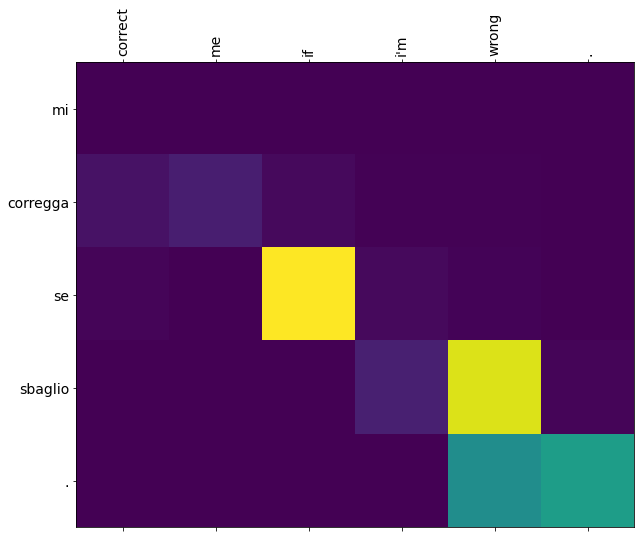

In [85]:
ita , out = predict(126700)

English:              my new job starts monday .
Translated(italian):  il mio nuovo lavoro comincia lunedi .


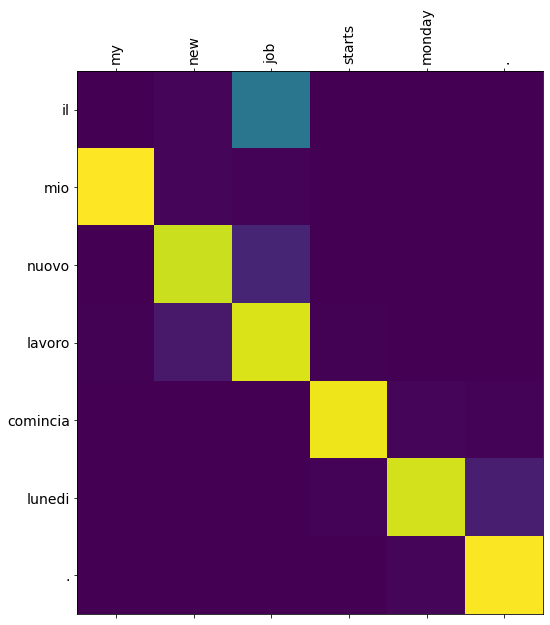

In [86]:
ita, out = predict(149000)

In [172]:
#Bleu-Score for Dot-Score Model

from nltk.translate.bleu_score import sentence_bleu
score = sentence_bleu(ita, out)
print("Bleu-score: ",score)

Bleu-score:  0.6147881529512643


**Model - 2 General_Score**


In [0]:
"General Score"

In [0]:
from tensorflow.keras import backend as K 
K.clear_session()

In [102]:
#Initialize Model 

encoder2 = Encoder(len(en_tokenizer.word_index)+1, 300, 256)
decoder2 = Decoder(len(ita_tokenizer.word_index)+1, 300, 256, 'general')
en_initial_states = encoder2.init_states(128)
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)

#training Step
@tf.function
def train_step2(source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    with tf.GradientTape() as tape:
        en_outputs = encoder2(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder2(
                decoder_in, de_state_h, de_state_c, en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    #Gradient Update
    variables = encoder2.trainable_variables + decoder2.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

import time
for e in range(25):
  start = time.time()
  #Saving Weights
  encoder2.save_weights(
            '/content/drive/My Drive/Attention Models/saved_model/Check2/Encoder/encoder_{}.h5'.format(e + 1))
  decoder2.save_weights(
            '/content/drive/My Drive/Attention Models/saved_model/Check2/Decoder/decoder_{}.h5'.format(e + 1))
  for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
    loss = train_step2(source_seq, target_seq_in,
                              target_seq_out, en_initial_states)

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(e + 1, batch, loss.numpy()))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.1153
Epoch 1 Batch 100 Loss 1.7000
Epoch 1 Batch 200 Loss 1.6604
Epoch 1 Batch 300 Loss 1.6032
Epoch 1 Batch 400 Loss 1.5006
Epoch 1 Batch 500 Loss 1.4569
Epoch 1 Batch 600 Loss 1.4743
Epoch 1 Batch 700 Loss 1.4231
Epoch 1 Batch 800 Loss 1.3644
Epoch 1 Batch 900 Loss 1.2159
Epoch 1 Batch 1000 Loss 1.2528
Epoch 1 Batch 1100 Loss 1.0949
Time taken for 1 epoch 333.62171721458435 sec

Epoch 2 Batch 0 Loss 1.0122
Epoch 2 Batch 100 Loss 0.9777
Epoch 2 Batch 200 Loss 0.9443
Epoch 2 Batch 300 Loss 0.8626
Epoch 2 Batch 400 Loss 0.7949
Epoch 2 Batch 500 Loss 0.7643
Epoch 2 Batch 600 Loss 0.7268
Epoch 2 Batch 700 Loss 0.7420
Epoch 2 Batch 800 Loss 0.6249
Epoch 2 Batch 900 Loss 0.6365
Epoch 2 Batch 1000 Loss 0.6324
Epoch 2 Batch 1100 Loss 0.5704
Time taken for 1 epoch 301.40501737594604 sec

Epoch 3 Batch 0 Loss 0.5002
Epoch 3 Batch 100 Loss 0.4870
Epoch 3 Batch 200 Loss 0.4944
Epoch 3 Batch 300 Loss 0.5002
Epoch 3 Batch 400 Loss 0.4905
Epoch 3 Batch 500 Loss 0.4198
Epoch 3 

In [0]:
import matplotlib
import matplotlib.pyplot as plt


#Predicting(Translating) Sentence
def predict2(i):
  en_out, state_h, state_c = encoder2(data_en[i:i+1],encoder.init_states(1))
  eng = [en_tokenizer.index_word[idx] for idx in data_en[i:i+1][0] if idx !=0]
  ita = [ita_tokenizer.index_word[idx] for idx in data_ita_in[i:i+1][0] 
                                    if idx !=0 
                                        and ita_tokenizer.index_word[idx]!='<start>']
  vec = np.array(ita_tokenizer.word_index['<start>']).reshape(1,1)
  out = []
  weights = []
  while(50):  
    de_out, state_h,state_c, w = decoder2(vec, state_h, state_c, en_out)
    vec = np.argmax(de_out[0][0]).reshape(1,1)
    if ita_tokenizer.index_word[np.argmax(de_out[0][0])] == '<end>':
      break
    out.append(ita_tokenizer.index_word[np.argmax(de_out[0][0])])
    weights.append(list(w[0][0].numpy()))

  print("English:             ",' '.join(eng))
  print("Translated(italian): ",' '.join(out))

  plot_attention(np.array(weights), eng, out)
  return ita, out

# function for plotting the attention weights
# https://www.tensorflow.org/tutorials/text/nmt_with_attention
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention[:,0:len(sentence)], cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

  plt.show()

English:              my new job starts monday .
Translated(italian):  il mio nuovo impiego comincia lunedi .


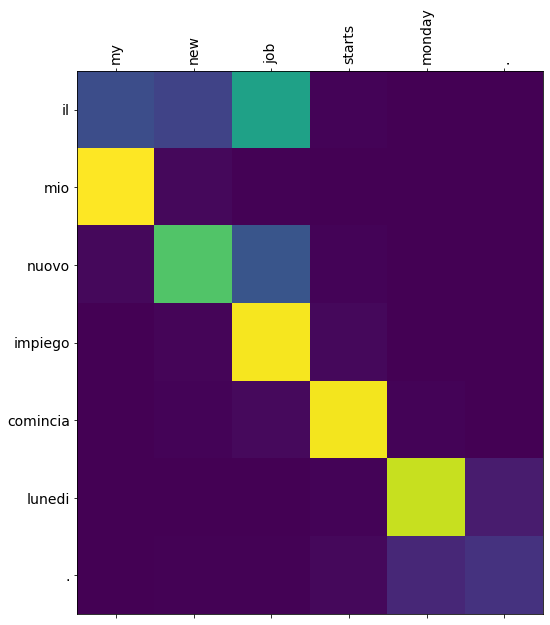

In [168]:
ita, out = predict2(148999)

English:              my robot's name is multi .
Translated(italian):  il mio robot si chiama multi .


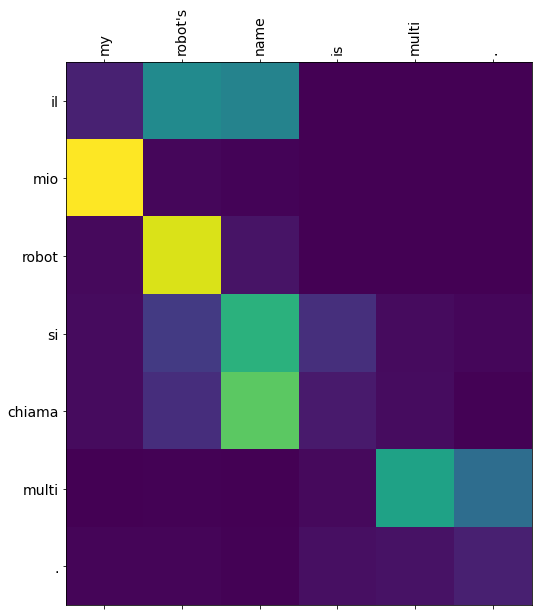

In [169]:
ita, out = predict2(149010)

In [170]:
#Bleu-Score for General-Score Model

print("Target: ",' '.join(ita))
print("Prediction: ",' '.join(out))

score = sentence_bleu(ita, out)
print("Bleu-score (General-Score): ",score)

Target:  il nome del mio robot e multi .
Prediction:  il mio robot si chiama multi .
Bleu-score (General-Score):  0.6147881529512643


**Model - 3 Concat_Score**

In [0]:
"Concate_Score"

In [0]:
from tensorflow.keras import backend as K 
K.clear_session()

In [148]:
#Initialize Model

encoder3 = Encoder(len(en_tokenizer.word_index)+1, 300, 256)
decoder3 = Decoder(len(ita_tokenizer.word_index)+1, 300, 256, 'concat')
en_initial_states = encoder3.init_states(128)
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)

#Train Step
@tf.function
def train_step3(source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    with tf.GradientTape() as tape:
        en_outputs = encoder3(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder3(
                decoder_in, de_state_h, de_state_c, en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    #Gradient Update
    variables = encoder3.trainable_variables + decoder3.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

import time
for e in range(25):
  start = time.time()
  #Saving Weights
  encoder3.save_weights(
            '/content/drive/My Drive/Attention Models/saved_model/Check3/Encoder/encoder_{}.h5'.format(e + 1))
  decoder3.save_weights(
            '/content/drive/My Drive/Attention Models/saved_model/Check3/Decoder/decoder_{}.h5'.format(e + 1))
  for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
    loss = train_step3(source_seq, target_seq_in,
                              target_seq_out, en_initial_states)

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(e +  1, batch, loss.numpy()))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.0512
Epoch 1 Batch 100 Loss 1.7350
Epoch 1 Batch 200 Loss 1.6528
Epoch 1 Batch 300 Loss 1.6437
Epoch 1 Batch 400 Loss 1.6548
Epoch 1 Batch 500 Loss 1.4654
Epoch 1 Batch 600 Loss 1.5036
Epoch 1 Batch 700 Loss 1.4238
Epoch 1 Batch 800 Loss 1.2735
Epoch 1 Batch 900 Loss 1.2592
Epoch 1 Batch 1000 Loss 1.1280
Epoch 1 Batch 1100 Loss 1.0652
Time taken for 1 epoch 363.07117986679077 sec

Epoch 2 Batch 0 Loss 0.9432
Epoch 2 Batch 100 Loss 0.9590
Epoch 2 Batch 200 Loss 0.9209
Epoch 2 Batch 300 Loss 0.8667
Epoch 2 Batch 400 Loss 0.7585
Epoch 2 Batch 500 Loss 0.7658
Epoch 2 Batch 600 Loss 0.6789
Epoch 2 Batch 700 Loss 0.6374
Epoch 2 Batch 800 Loss 0.6210
Epoch 2 Batch 900 Loss 0.5739
Epoch 2 Batch 1000 Loss 0.5448
Epoch 2 Batch 1100 Loss 0.5309
Time taken for 1 epoch 321.28168773651123 sec

Epoch 3 Batch 0 Loss 0.4708
Epoch 3 Batch 100 Loss 0.4332
Epoch 3 Batch 200 Loss 0.4225
Epoch 3 Batch 300 Loss 0.3912
Epoch 3 Batch 400 Loss 0.3845
Epoch 3 Batch 500 Loss 0.3645
Epoch 3 

In [0]:
import matplotlib
import matplotlib.pyplot as plt

#Predicting(Translating) Sentence
def predict3(i):
  en_out, state_h, state_c = encoder3(data_en[i:i+1],encoder.init_states(1))
  eng = [en_tokenizer.index_word[idx] for idx in data_en[i:i+1][0] if idx !=0]
  ita = [ita_tokenizer.index_word[idx] for idx in data_ita_in[i:i+1][0] 
                                    if idx !=0 
                                        and ita_tokenizer.index_word[idx]!='<start>']
  vec = np.array(ita_tokenizer.word_index['<start>']).reshape(1,1)
  out = []
  weights = []
  while(50):  
    de_out, state_h,state_c, w = decoder3(vec, state_h, state_c, en_out)
    vec = np.argmax(de_out[0][0]).reshape(1,1)
    if ita_tokenizer.index_word[np.argmax(de_out[0][0])] == '<end>':
      break
    out.append(ita_tokenizer.index_word[np.argmax(de_out[0][0])])
    weights.append(list(w[0][0].numpy()))

  print("English:             ",' '.join(eng))
  print("Translated(italian): ",' '.join(out))

  plot_attention(np.array(weights), eng, out)
  return ita, out

# https://www.tensorflow.org/tutorials/text/nmt_with_attention
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention[:,0:len(sentence)], cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

  plt.show()

English:              are you brave ?
Translated(italian):  sei coraggiosa ?


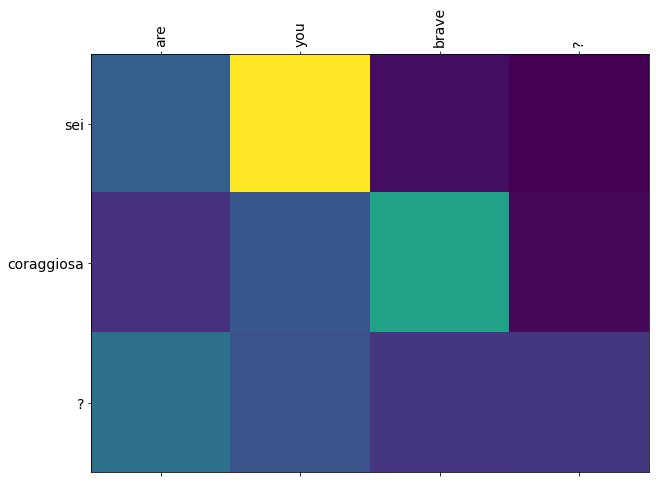

In [156]:
ita, out = predict3(11199)

English:              thanks for your concern .
Translated(italian):  grazie per il vostro interesse .


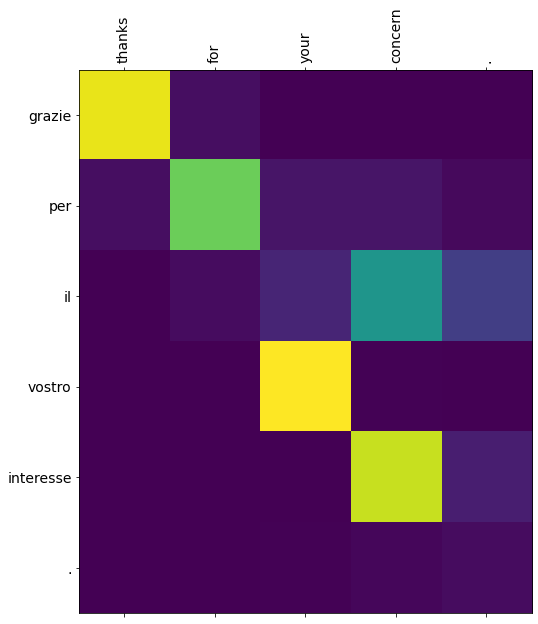

In [157]:
ita, out = predict3(134499)

English:              i feel so much better .
Translated(italian):  mi sento molto meglio .


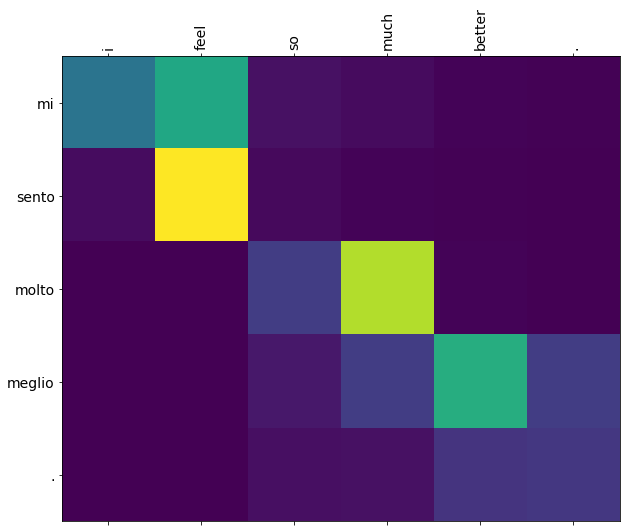

In [158]:
ita , out = predict3(100000)

In [163]:
#Bleu-Score for Concat-Score Model

print("Target: ",' '.join(ita))
print("Prediction: ",' '.join(out))
score = sentence_bleu(ita, out)
print("Bleu-score: ",score)

Target:  mi sento molto meglio .
Prediction:  mi sento molto meglio .
Bleu-score:  0.668740304976422


**Final Observation**

**Encoder:**  Here in Attention We takes Simple Encoder Architecture 

**Decoder:**  But Here in Decoder Layer We have slightly Different Architecture With Attention Mechanism

In This Assignment We applied One Step Decoder Which Apply Attention Mechanism and Decoder Block Step by Step for Each Time-stamp..
So Basically, Vanila Encoder-Decoder Can not work Excellently when Machine Translation Task contains Long Sequences....
that's Why Attention Based Mechanism Comes in Picture, Attention Layer Finds the Word from Input Space which help alot to translate the word in other Language for specific Timestamp by Calculating the Score

In this Assignment we used Luong - Style Attention Which is very similar to Bahadanau Attention But one thing is differnt is the Method of Calculating Score for Global Attention which we can see by reading this Paper..
https://arxiv.org/pdf/1508.04025.pdf

So Luong-style Attention have the three Scoring Methods
1) Dot-Score
2) General-Score
3) Concat-Score

After Applying the All three score in Training Process we used The BLEU Score for Evaluation Process .

We got same Bleu- Score  Aroung --> 0.61 in Case of applying Dot and General Score in Attention Mechanism  But with Concat Score we get slighty good BLUE Result --> 0.6687 



